# Homework #5 - Deploying Model in GCP (File 1 of 2)

* File 1: Notebook that creates the model and save the model on the GCP AI platform
* File 2: Notebook that is calling the service on GCP AI platform

#### Submitted by Jocelyn Prince (2019/12/05)
---

## Sentiment Analysis Project - NLP with TF.HUB tf2-preview/nnlm-en-dim128 Module

### Description
Deploying a model on Google's AI-Platform (also called ML Engine) and demonstrate the model returning a prediction.

1. Use the free tier of GCP: https://cloud.google.com/free/
2. Train a model using any dataset you want using keras, tensorflow, XGBoost or scikit-learn. You can do the training locally (or on colab)
3. Deploy the model on GCP's AI-Platform
4. Send a request to the AI-Platform and print out the prediction (File 2)

---------------

Details:
* Dataset for training: Twitter US Airline Tweets from Feb 2015 (source: https://www.figure-eight.com/data-for-everyone/)
* Module used for word embeddings: tf2-preview/nnlm-en-dim128 from tf.hub

References:

https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

https://arxiv.org/pdf/1802.05365.pdf
https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

-----

# Import Libraries

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [0]:
tf.__version__

'2.0.0'

In [0]:
tf.test.is_gpu_available()

True

In [0]:
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

In [0]:
!pip3 install spacy --user

In [0]:
!python3 -m spacy download en --user


In [0]:
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy

# Import Dataset: US Airline Tweets 
#### (source: https://www.figure-eight.com/data-for-everyone/)

In [0]:
# Import data set
df = pd.read_csv("Tweets.csv")
df.shape

(14640, 15)

# Explore Data

Data Dictionary

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

There are 15 variables:

tweet_id
airline_sentiment
airline_sentiment_confidence
negativereason
negativereason_confidence
airline
airline_sentiment_gold
name
negativereason_gold
retweet_count
text
tweet_coord
tweet_created
tweet_location
user_timezone

The tweet field is "text".
The target field (label) is "airline_sentiment". Values are : positive, neutral or negative

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [0]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [0]:
df.airline_sentiment.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [0]:
df.text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [0]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
df.text[0:10]

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
7    @VirginAmerica Really missed a prime opportuni...
8      @virginamerica Well, I didn't…but NOW I DO! :-D
9    @VirginAmerica it was amazing, and arrived an ...
Name: text, dtype: object

In [0]:
len(df.text[9])

80

# Prepare X_train, y_train, X_test, y_test


In [0]:
train_set, test_set = train_test_split(df[["tweet_id", "text", "airline_sentiment"]], test_size=0.2, random_state=42)


In [0]:
X_train = train_set.drop("airline_sentiment", axis=1) # drop labels for training set
y_train = train_set["airline_sentiment"].copy()

In [0]:
X_test = test_set.drop("airline_sentiment", axis=1) # drop labels for testing datasset
y_test = test_set["airline_sentiment"].copy()

In [0]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("X_test: "+ str(X_test.shape))
print("y_train: "+ str(y_train.shape))
print("y_test: "+ str(y_test.shape))

X_train: (11712, 2)<class 'pandas.core.frame.DataFrame'>
X_test: (2928, 2)
y_train: (11712,)
y_test: (2928,)


In [0]:
print(type(y_train))
print(y_train.describe)

<class 'pandas.core.series.Series'>
<bound method NDFrame.describe of 750      negative
6875     negative
7598     positive
14124    negative
6187      neutral
           ...   
5191     positive
13418    negative
5390     negative
860      negative
7270      neutral
Name: airline_sentiment, Length: 11712, dtype: object>


In [0]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:20]

array([0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0])

In [0]:
y_train = keras.utils.to_categorical(y_train)

In [0]:
y_test = keras.utils.to_categorical(y_test)

In [0]:
y_train[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

# Data Preprocessing

In [0]:
# remove URL's from train and test
X_train['clean_tweet'] = X_train['text'].apply(lambda x: re.sub(r'http\S+', '', x))
X_test['clean_tweet'] = X_test['text'].apply(lambda x: re.sub(r'http\S+', '', x))

In [0]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

X_train['clean_tweet'] = X_train['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
X_test['clean_tweet'] = X_test['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
X_train['clean_tweet'] = X_train['clean_tweet'].str.lower()
X_test['clean_tweet'] = X_test['clean_tweet'].str.lower()

# remove numbers
X_train['clean_tweet'] = X_train['clean_tweet'].str.replace("[0-9]", " ")
X_test['clean_tweet'] = X_test['clean_tweet'].str.replace("[0-9]", " ")

# remove whitespaces
X_train['clean_tweet'] = X_train['clean_tweet'].apply(lambda x:' '.join(x.split()))
X_test['clean_tweet'] = X_test['clean_tweet'].apply(lambda x: ' '.join(x.split()))

### Lemmatize (Normalize) Tweets

In [0]:
# import spaCy's language model
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [0]:
X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

In [0]:
X_train.sample(10)

,tweet_id,text,clean_tweet
6815,570237343669608448,@JetBlue Thank you very much!,jetblue thank -PRON- very much
12861,569998668775862272,"@AmericanAir I had it until last night, but be...","americanair i have -PRON- until last night , b..."
4720,569901925358968832,@SouthwestAir Just got companion pass and tryi...,southwestair just get companion pass and try t...
11637,567859601900740609,@USAirways flights keep getting delayed and Ca...,usairway flight keep get delay and cancel flig...
1046,569953575226310656,@united nice your app says US 4972 delayed by ...,united nice -PRON- app say -PRON- delay by wea...
13691,569745801121009664,"@AmericanAir - for the past 5.5 hours, call vo...","americanair for the past . hour , call volume ..."
7759,569273297491378176,@JetBlue Hello we are doing a world record att...,jetblue hello -PRON- be do a world record atte...
8680,568031723004555264,"@JetBlue just a heads up, this page no longer ...","jetblue just a head up , this page no longer e..."
9383,569960704717008896,@USAirways you guys Cancelled Flightled two of...,usairway -PRON- guy cancel flightle two of -PR...
5986,568445415768477696,@SouthwestAir @FortuneMagazine Congrats!,southwestair fortunemagazine congrat


In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [0]:
print(X_train[0:10])

['united -PRON- be offer us room for people fail'
 'jetblue jfk nyc staff be amazing . the lax jetblue ... send an email with detail but -PRON- be a disappointing experience jetbluecheep'
 'jetblue well , the last update be in the right direction , at least -PRON- will keep -PRON- finger cross .'
 'americanair flight still sit at dfw wait for baggage to be load'
 'southwestair be -PRON- companion pass break today purchase.error.invalidloyaltymemberaccountstatus sw vyil xklrog fs ja'
 'united push hour on hold . priceless .'
 'americanair -PRON- have be try to reach -PRON- customer service for two day . i have receive zero response . never travel aa again .'
 'united jx s t if -PRON- can out today would be great -PRON- be -PRON- honeymoon and this delay -PRON- have put a damper on iy'
 'americanair -PRON- have be call -PRON- for straight day and no one pick up . sure there be storm but there be also customer holler'
 'usairway ... what be go on at phlairport -PRON- have be sit at the ga

# Create Model using tf.hub: tf2-preview/nnlm-en-dim128

In [0]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 124,646,915
Trainable params: 4,227
Non-trainable params: 124,642,688
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

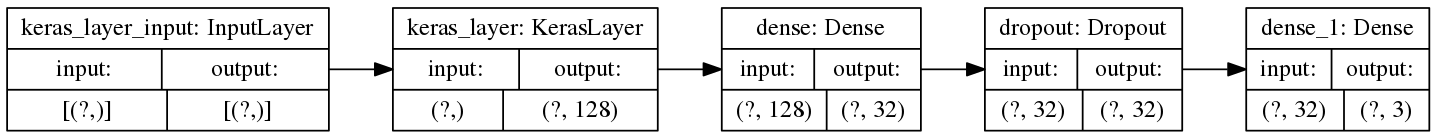

In [0]:
keras.utils.plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

# Execute Model

In [0]:
t1 = time.time()
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40, 
                 batch_size=32, 
                 # callbacks=callbacks, 
                 # validation_split=0.1, 
                 verbose = 1)
t2 = time.time()

Train on 11712 samples
Epoch 1/40
11712/11712 [==============================] - 7s 634us/sample - loss: 0.8061 - accuracy: 0.6569
Epoch 2/40
11712/11712 [==============================] - 4s 316us/sample - loss: 0.6585 - accuracy: 0.7377
Epoch 3/40
11712/11712 [==============================] - 4s 317us/sample - loss: 0.6223 - accuracy: 0.7538
Epoch 4/40
11712/11712 [==============================] - 4s 316us/sample - loss: 0.6024 - accuracy: 0.7648
Epoch 5/40
11712/11712 [==============================] - 4s 314us/sample - loss: 0.5898 - accuracy: 0.7688
Epoch 6/40
11712/11712 [==============================] - 4s 314us/sample - loss: 0.5818 - accuracy: 0.7694
Epoch 7/40
11712/11712 [==============================] - 4s 314us/sample - loss: 0.5770 - accuracy: 0.7752
Epoch 8/40
11712/11712 [==============================] - 4s 315us/sample - loss: 0.5728 - accuracy: 0.7751
Epoch 9/40
11712/11712 [==============================] - 4s 314us/sample - loss: 0.5710 - accuracy: 0.7700
Epoch

In [0]:
print("Execution time: {0:5.1f} min for {1:3.0f} epochs".format((t2 - t1)/60, len(hist.epoch)))

Execution time:   2.5 min for  40 epochs


<function matplotlib.pyplot.show(*args, **kw)>

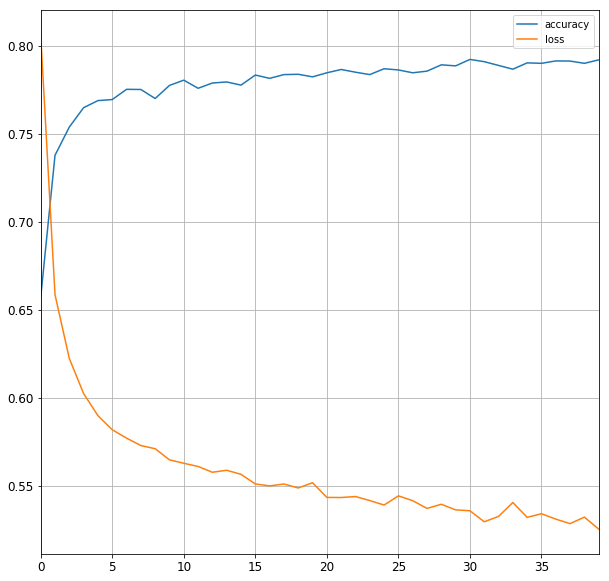

In [0]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

# Evaluate Model

In [0]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

2928/1 - 1s - loss: 0.4394 - accuracy: 0.7872
[0.5211793249422084, 0.7872268]


In [0]:
print(X_train[0:10])

['united -PRON- be offer us room for people fail'
 'jetblue jfk nyc staff be amazing . the lax jetblue ... send an email with detail but -PRON- be a disappointing experience jetbluecheep'
 'jetblue well , the last update be in the right direction , at least -PRON- will keep -PRON- finger cross .'
 'americanair flight still sit at dfw wait for baggage to be load'
 'southwestair be -PRON- companion pass break today purchase.error.invalidloyaltymemberaccountstatus sw vyil xklrog fs ja'
 'united push hour on hold . priceless .'
 'americanair -PRON- have be try to reach -PRON- customer service for two day . i have receive zero response . never travel aa again .'
 'united jx s t if -PRON- can out today would be great -PRON- be -PRON- honeymoon and this delay -PRON- have put a damper on iy'
 'americanair -PRON- have be call -PRON- for straight day and no one pick up . sure there be storm but there be also customer holler'
 'usairway ... what be go on at phlairport -PRON- have be sit at the ga

In [0]:
predictions = model.predict(X_train[:10], batch_size=None, verbose=0)
print(predictions.round(1))

[[0.8 0.2 0. ]
 [0.4 0.  0.6]
 [0.5 0.3 0.2]
 [1.  0.  0. ]
 [0.1 0.6 0.4]
 [0.9 0.  0. ]
 [1.  0.  0. ]
 [0.6 0.3 0.1]
 [0.9 0.  0. ]
 [1.  0.  0. ]]


In [0]:
y_train[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

# Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

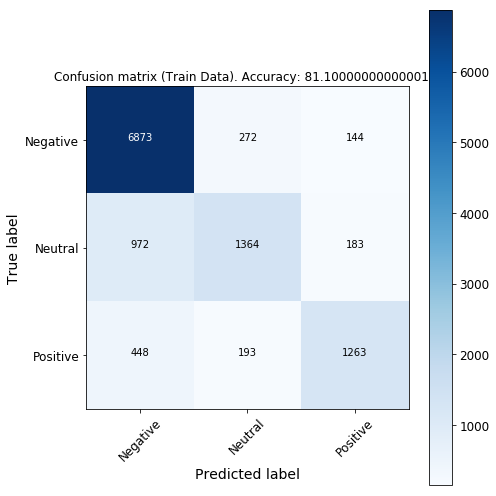

In [0]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title='Confusion matrix (Train Data).' + " Accuracy: " + str(accuracy.round(3)*100) + "%" );

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

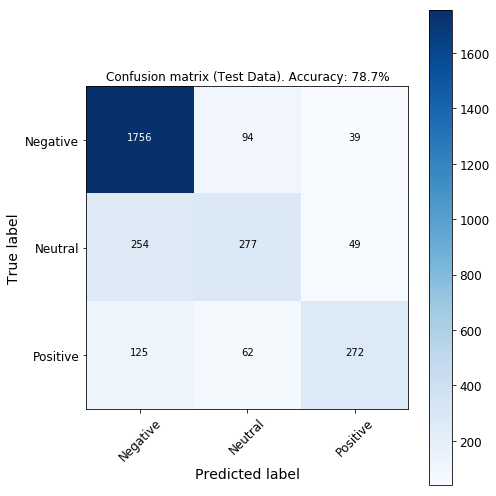

In [0]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title='Confusion matrix (Test Data).' + " Accuracy: " + str(accuracy.round(3)*100) + "%" );

# Test the Model with some sentences

In [0]:
# indices:
# Negative - Neutral - Positive

In [0]:
print(model.predict(["United be search my suitcase"]).round(1))

[[0.8 0.2 0. ]]


In [0]:
print(model.predict(["I hate food"]).round(1))

[[0.8 0.1 0. ]]


In [0]:
print(model.predict(["be cold"]).round(1))

[[0.6 0.2 0.1]]


In [0]:
print(model.predict(["seat be comfortable"]).round(1))

[[0.3 0.1 0.6]]


In [0]:
print(model.predict(["seat not be comfortable"]).round(1))

[[0.9 0.  0.1]]


In [0]:
print(model.predict(["attendant be nice"]).round(1))

[[0.1 0.  0.9]]


# Save Keras Model

In [0]:
# save model and architecture to single file
model_version = "0001"
model_name = "JP_sentiment_analysis_service"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: JP_sentiment_analysis_service/0001/assets


INFO:tensorflow:Assets written to: JP_sentiment_analysis_service/0001/assets


Saved model to disk


In [0]:
!saved_model_cli show --dir {model_path}

2019-12-09 21:12:34.251754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
The given SavedModel contains the following tag-sets:
serve


In [0]:
!saved_model_cli show --dir {model_path} --tag_set serve

2019-12-09 21:12:39.705170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [0]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

2019-12-09 21:12:48.232252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict


In [0]:
!saved_model_cli show --dir {model_path} --all

2019-12-09 21:12:53.370525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_keras_layer_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall_2:0
  Method name is: t

-------- 
### Comments
A savedModel contains one or more metagraphs.

A metagraph contains:
* Input names
* Output names
* Types
* Shapes

Tags like "train", "gpu and the default: "serve"
Below we test the savedModel with a numpy input. This is just for local testing.

---------





In [0]:
X_new = X_test[0:3]
np.save("my_sentiment_analysis_tests.npy", X_new)

In [0]:
input_name = model.input_names[0]
input_name

'keras_layer_input'

!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_sentiment_analysis_tests.npy

# Copy Model to Google Storage (Bucket)

In [0]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

env: GOOGLE_APPLICATION_CREDENTIALS=''


In [0]:
PROJECT_ID = "utopian-rush-255612" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "utopian-rush-255612-bucket_ml" #@param {type:"string"}
REGION = "us-east1" #@param {type:"string"}

! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

Updated property [core/project].
utopian-rush-255612


In [0]:
# Create Bucket
# ! gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME
# Display what is in the bucket
!gsutil ls -al gs://$BUCKET_NAME

                                 gs://utopian-rush-255612-bucket_ml/CreditFault/
                                 gs://utopian-rush-255612-bucket_ml/YCBS258/
                                 gs://utopian-rush-255612-bucket_ml/my_rnn/
                                 gs://utopian-rush-255612-bucket_ml/my_sentiment_analysis_model/


In [0]:
JOB_DIR = 'gs://' + BUCKET_NAME + '/my_sentiment_analysis_model'

In [0]:
# Export the model to a local SavedModel directory 
# export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
# print("Model exported to: ", export_path)

# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.saved_model.save(model, JOB_DIR + '/0001')
# print("Model exported to: ", export_path)

INFO:tensorflow:Assets written to: gs://utopian-rush-255612-bucket_ml/my_sentiment_analysis_model/0001/assets


INFO:tensorflow:Assets written to: gs://utopian-rush-255612-bucket_ml/my_sentiment_analysis_model/0001/assets


# Create the Model in the AI Platform

In [0]:
MODEL_NAME = "my_sentiment_analysis"

! gcloud ai-platform models create $MODEL_NAME --regions $REGION

ERROR: (gcloud.ai-platform.models.create) Resource in project [utopian-rush-255612] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


# Create the Version of the Model in AI Platform
## Note: I created the version directly in the GUI

MODEL_VERSION = "v1"

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/0001/

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

# Create Service Account to Access the Service in a Secure Fashion

### I created the service account directly in the GUI

### I downloaded the secure key (json file) in my jupyter space to be used later by another notebook
